In [1]:
import sys
sys.path.append(r'C:\Users\USER\Documents\GitHub\frft')
sys.path.append(r'C:\Users\USER\Documents\GitHub\DLOCT\Analysis_cGAN')
import numpy as np
import os
from numpy.fft import fft, ifft, fftshift
from scipy.signal import hilbert
from tqdm import tqdm
from tftb.processing import WignerVilleDistribution
import matplotlib.pyplot as plt
import torch
import frft
import frft_gpu as frft_g
import time
from Deep_Utils import dbscale
import matplotlib.animation as animation

def extract_dimensions(file_name):
    parts = file_name.split('_')
    dimensions = []
    for part in parts:
        if 'z=' in part or 'x=' in part or 'y=' in part:
            number = int(part.split('=')[-1])
            dimensions.append(number)
    return tuple(dimensions)

def read_tomogram(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width),order='F')
    return tomogram

def read_tomogram2(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width))
    return tomogram

def calculate_sharpness(signal):
    second_derivative = np.diff(signal, n=2)
    sharpness = np.sum(np.abs(second_derivative))
    return sharpness

# Optimización del parámetro de orden 'a'
def optimize_frft_order(signal):
    nSnapshots = 500  # Resolución del vector 'a'
    alpha = np.linspace(0., 2., nSnapshots)
    signal_gpu = torch.from_numpy(signal).cuda()
    sharpness_values = []
    best_sharpness = 0
    best_a = 0

    for al in tqdm(alpha, total=alpha.size):
        fobj_1d = frft_g.frft(signal_gpu, al)
        fobj_1d_cpu = torch.Tensor.cpu(fobj_1d).numpy()
        fobj_1d_shifted = np.fft.fftshift(fobj_1d_cpu)
        sharpness = calculate_sharpness(fobj_1d_shifted)
        sharpness_values.append(sharpness)
        if sharpness > best_sharpness:
            best_sharpness = sharpness
            best_a = al

    return best_a, sharpness_values

In [2]:
pathcomplex = r'E:\DLOCT\Experimental_Data_complex\tomogram_artifacts\depth_chicken_breast'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram2(real_file_path, dimensions)
        tomImag = read_tomogram2(imag_file_path, dimensions)
        tomcc = tomReal + 1j * tomImag
        fringescc = fftshift(ifft(tomcc,axis=0),axes=0)
        # fringescc = np.stack((fringescc.real,fringescc.imag),axis=3)
        fringescc = fringescc.real
        del tomImag, tomReal, tomcc

In [3]:
fringescc = fringescc[:,:,250:258]

In [4]:



pathcomplex = r'C:\Users\USER\Documents\GitHub\[s.fovea]11bscanNoartifacts'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram(real_file_path, dimensions)
        tomImag = read_tomogram(imag_file_path, dimensions)
        tom = tomReal + 1j * tomImag
        fringes = fftshift(ifft(tom,axis=0),axes=0)
        fringes = np.stack((fringes.real,fringes.imag),axis=3)
        del tomImag, tomReal


fringesccHilbert = hilbert(fringescc[:,:,:],axis=0)
fringesccAnalytic = fringescc[:,:,:] + 1j*fringesccHilbert
fringesccAnalytic = np.stack((fringesccAnalytic.real,fringesccAnalytic.imag),axis=3)
del fringesccHilbert

Text(0.5, 1.0, 'fft fringes+1j*H(fringes)')

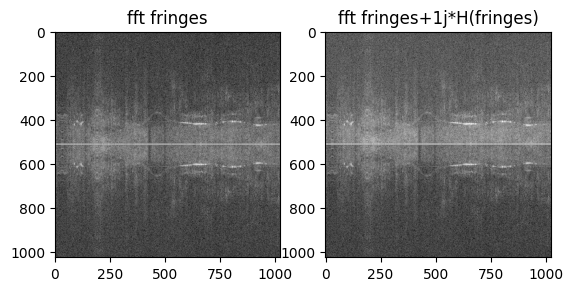

In [5]:
fig,axs = plt.subplots(ncols=2,nrows=1)
axs[0].imshow(dbscale(fft(fringescc[:,:,7],axis=0)),cmap='gray',vmax=130,vmin=50)
axs[0].set_title('fft fringes')
axs[1].imshow(dbscale(fft(fringesccAnalytic[:,:,7,0]+1j*fringesccAnalytic[:,:,7,1],axis=0)),cmap='gray',vmax=130,vmin=50)
axs[1].set_title('fft fringes+1j*H(fringes)')

In [6]:

def frft_apply(signal, a):
    """Aplica la FrFT a la señal sin procesamiento adicional."""
    # signal = signal + 1j*hilbert(signal)
    signal_gpu = torch.from_numpy(signal).cuda()
    optimal_signal_gpu = frft_g.frft(signal_gpu, a)
    optimal_signal = (torch.Tensor.cpu(optimal_signal_gpu).numpy())
    return optimal_signal

# Aplicar el proceso a toda la primera B-scan
bscan = fringesccAnalytic[:,:,0,0]+1j*fringesccAnalytic[:,:,0,1]

In [7]:
nSnapshots = 500
alpha = np.linspace(0., 2., nSnapshots)
bscanfrft = []
for a in tqdm(alpha):
    frft_bscan = np.zeros_like(bscan,dtype='complex')
    for x in range(bscan.shape[1]):
        line = bscan[:, x]
        frft_line = frft_apply(line, a)
        frft_bscan[:, x] = frft_line
    bscanfrft.append(frft_bscan)

100%|██████████| 500/500 [07:33<00:00,  1.10it/s]


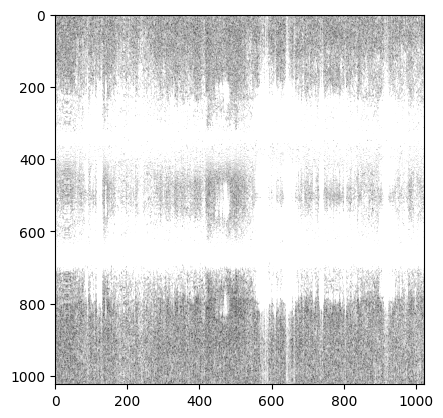

In [8]:
plt.imshow(dbscale(bscanfrft[300]), cmap='gray',vmax=30,vmin=0)

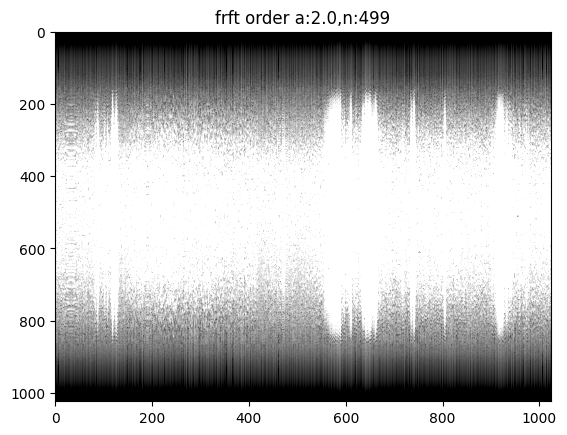

In [9]:

# Crear la figura y el eje
fig, ax = plt.subplots()
image = ax.imshow(dbscale(bscanfrft[0]), cmap='gray', aspect='auto',vmax=30,vmin=0)

# Función de actualización para la animación
def update(frame):
    image.set_data(dbscale(bscanfrft[frame]))
    ax.set_title(f'frft order a:{alpha[frame]},n:{frame}')
    return image,

# Crear la animación
ani = animation.FuncAnimation(fig, update, frames=len(bscanfrft), interval=5)
ani.save(filename=r"C:\Users\USER\Documents\animaciones\artifacts_chicken.html", writer="html")

plt.show()

In [8]:
mid = int(len(bscanfrft[0])/2)
n = 352
half1 = bscanfrft[n][0:mid,:]
half2 = np.flip(bscanfrft[n][mid:,:])
half3 = (bscanfrft[n][mid:,:])
tom = half1+half2
tom2 = half1+half3

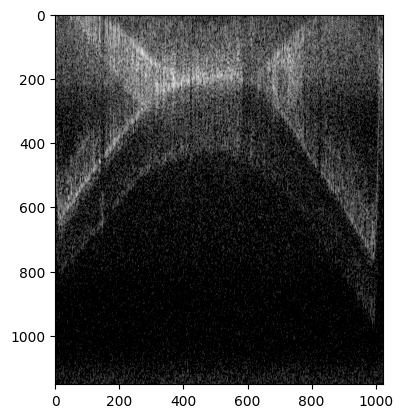

In [9]:
plt.imshow(dbscale(half1),cmap='gray',vmax=30,vmin=0)

100%|██████████| 500/500 [07:26<00:00,  1.12it/s]


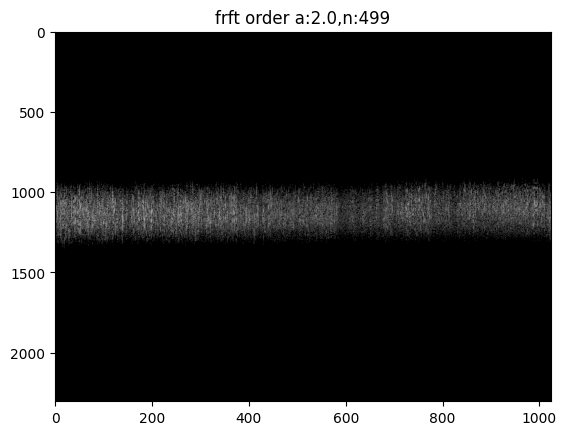

In [10]:
bscantargetfrft = []
bscannoart = fringes[:,:,0,0]+1j*fringes[:,:,0,1]
for a in tqdm(alpha):
    frft_bscan = np.zeros_like(bscannoart,dtype='complex')
    for x in range(bscannoart.shape[1]):
        line = bscannoart[:, x]
        frft_line = frft_apply(line, a)
        frft_bscan[:, x] = frft_line
    bscantargetfrft.append(frft_bscan)

# Crear la figura y el eje
fig, ax = plt.subplots()
image = ax.imshow(dbscale(bscantargetfrft[0]), cmap='gray', aspect='auto',vmax=30,vmin=0)

# Función de actualización para la animación
def update(frame):
    image.set_data(dbscale(bscantargetfrft[frame]))
    ax.set_title(f'frft order a:{alpha[frame]},n:{frame}')
    return image,

# Crear la animación
ani = animation.FuncAnimation(fig, update, frames=len(bscantargetfrft), interval=5)
ani.save(filename=r"C:\Users\USER\Documents\animaciones\noartifacts.html", writer="html")

plt.show()

In [22]:
pathcomplex = r'C:\Users\USER\Documents\GitHub\Simulated_Data_Complex\tom2'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        print(f'real: {real_file_path}')
        print(f'imag: {imag_file_path}')
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram(real_file_path, dimensions)
        tomImag = read_tomogram(imag_file_path, dimensions)
        tom = tomReal + 1j * tomImag
        fringessimcc = fftshift(ifft(tom,axis=0),axes=0)
        fringessimcc = np.stack((fringessimcc.real,fringessimcc.imag),axis=3)
        del tomImag, tomReal


pathcomplex = r'C:\Users\USER\Documents\GitHub\Simulated_Data_Complex\tom1'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        print(f'real: {real_file_path}')
        print(f'imag: {imag_file_path}')
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram(real_file_path, dimensions)
        tomImag = read_tomogram(imag_file_path, dimensions)
        tom = tomReal + 1j * tomImag
        fringessim = fftshift(ifft(tom,axis=0),axes=0)
        fringessim = np.stack((fringessim.real,fringessim.imag),axis=3)
        del tomImag, tomReal

fringessimccHilbert = hilbert(fringessimcc[:,:,:,0],axis=0)
fringessimccAnalytic = fringessimcc[:,:,:,0] + 1j*fringessimccHilbert
fringessimccAnalytic = np.stack((fringessimccAnalytic.real,fringessimccAnalytic.imag),axis=3)
del fringessimccHilbert

real: C:\Users\USER\Documents\GitHub\Simulated_Data_Complex\tom2\tom2_real_val_z=512_x=512_y=8.bin
imag: C:\Users\USER\Documents\GitHub\Simulated_Data_Complex\tom1\tom1_imag_val_z=512_x=512_y=8.bin
real: C:\Users\USER\Documents\GitHub\Simulated_Data_Complex\tom1\tom1_real_val_z=512_x=512_y=8.bin
imag: C:\Users\USER\Documents\GitHub\Simulated_Data_Complex\tom2\tom2_imag_val_z=512_x=512_y=8.bin


Text(0.5, 1.0, 'fft fringes+1j*H(fringes)')

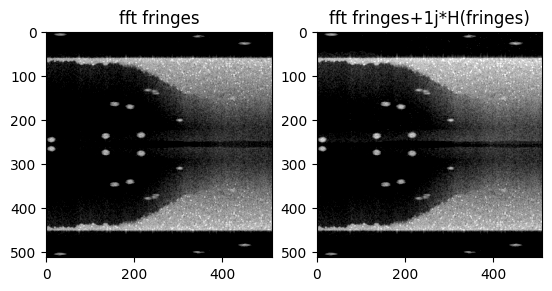

In [23]:
fig,axs = plt.subplots(ncols=2,nrows=1)
axs[0].imshow(dbscale(fft(fringessimcc[:,:,0,0],axis=0)),cmap='gray',vmax=130,vmin=50)
axs[0].set_title('fft fringes')
axs[1].imshow(dbscale(fft(fringessimccAnalytic[:,:,0,0]+1j*fringessimccAnalytic[:,:,0,1],axis=0)),cmap='gray',vmax=130,vmin=50)
axs[1].set_title('fft fringes+1j*H(fringes)')

In [24]:
bscansimfrft = []
bscansim = fringessimccAnalytic[:,:,0,0]+1j*fringessimccAnalytic[:,:,0,1]
for a in tqdm(alpha):
    frft_bscan = np.zeros_like(bscansim,dtype='complex')
    for x in range(bscansim.shape[1]):
        line = bscansim[:, x]
        frft_line = frft_apply(line, a)
        frft_bscan[:, x] = frft_line
    bscansimfrft.append(frft_bscan)

100%|██████████| 500/500 [03:00<00:00,  2.77it/s]


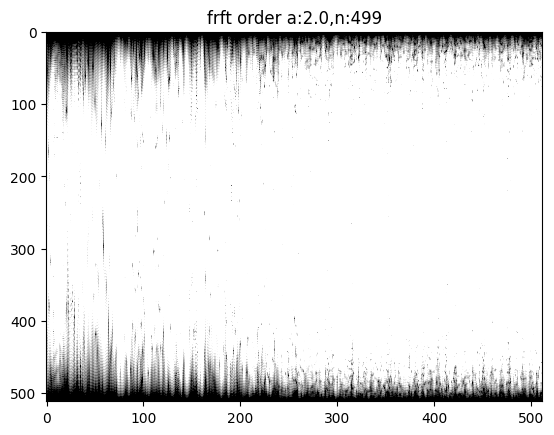

In [25]:
# Crear la figura y el eje
fig, ax = plt.subplots()
image = ax.imshow(dbscale(bscansimfrft[0]), cmap='gray', aspect='auto',vmax=30,vmin=0)

# Función de actualización para la animación
def update(frame):
    image.set_data(dbscale(bscansimfrft[frame]))
    ax.set_title(f'frft order a:{alpha[frame]},n:{frame}')
    return image,

# Crear la animación
ani = animation.FuncAnimation(fig, update, frames=len(bscansimfrft), interval=5)
ani.save(filename=r"C:\Users\USER\Documents\animaciones\simartifacts.html", writer="html")

plt.show()